<a href="https://colab.research.google.com/github/MJsanflo/ias_bai_2324/blob/main/ias_bai_2324_nanoGPT_multiplication_relative_pe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training and evaluating transformer for multipliatons

## Setup

### Setup google drive folder

You might have to create a folder named bai where the path points to.
Then create a folder named data/multiplicaton and a folder named out-multi.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/bai/"

Mounted at /content/drive


### Install libraries

In [ ]:
!pip install torch numpy datasets tiktoken wandb tqdm transformers matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


### Log into wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!
Exception ignored in atexit callback: <function _Manager._atexit_setup.<locals>.<lambda> at 0x7e52593d3f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_manager.py", line 156, in <lambda>
    self._atexit_lambda = lambda: self._atexit_teardown()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_manager.py", line 165, in _atexit_teardown
    self._teardown(exit_code)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_manager.py", line 176, in _teardown
    result = self._service.join()
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/service/service.py", line 250, in join
    ret = self._internal_proc.wait()
  File "/usr/lib/

### Check gpu config

In [ ]:
# Only run when using GPU
!ldconfig /usr/lib64-nvidia

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link



### Set global variables as config

In [ ]:
out_dir = "out-multi"
eval_interval = 250  # keep frequent because we'll overfit
eval_iters = 200
log_interval = 50  # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = True
wandb_project = "multiplication-char"
wandb_run_name = "relative_pos_enc_100k"  # 'run' + str(time.time())
init_from = "resume"  # change to resume if you have a model already

dataset = "multiplication"
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256  # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.0

pos_enc = "relative"  # absolute or relative
learning_rate = 1e-3  # with baby networks can afford to go a bit higher
max_iters = 100000
lr_decay_iters = 100000  # make equal to max_iters usually
min_lr = 1e-4  # learning_rate / 10 usually
beta2 = 0.99  # make a bit bigger because number of tokens per iter is small
warmup_iters = 100  # not super necessary potentially

device = "cuda"  # run on gpu
compile = True  # do  torch compile the model


### Import all dependencies

In [ ]:
import numpy as np

import pickle
import random
import os
import tiktoken
import time
import math
import inspect
from dataclasses import dataclass
from contextlib import nullcontext
from random import randint

import torch.nn as nn
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from torch.nn import functional as F

## Training

### Generate files for training and evaluation

If these files exist on the dive than you dont have to rerun these

In [ ]:
random.seed(42)
max_num_of_digits = 3
min_num_of_digits = 1

def prepare(input_file_path: str):
    with open(input_file_path, "r") as f:
        data = f.read()
    print(f"length of dataset in characters: {len(data):,}")

    # get all the unique characters that occur in this text
    chars = sorted(list(set(data)))
    vocab_size = len(chars)
    print("all the unique characters:", "".join(chars))
    print(f"vocab size: {vocab_size:,}")

    # create a mapping from characters to integers
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}

    def encode(s):
        return [stoi[c] for c in s]  # encoder: take a string, output a list of integers

    def decode(l):
        return "".join(
            [itos[i] for i in l]
        )  # decoder: take a list of integers, output a string

    # create the train and test splits
    n = len(data)
    train_data = data[: int(n * 0.9)]
    val_data = data[int(n * 0.9) :]

    # encode both to integers
    train_ids = encode(train_data)
    val_ids = encode(val_data)
    print(f"train has {len(train_ids):,} tokens")
    print(f"val has {len(val_ids):,} tokens")

    # export to bin files
    train_ids = np.array(train_ids, dtype=np.uint16)
    val_ids = np.array(val_ids, dtype=np.uint16)
    train_ids.tofile(os.path.join(data_folder, dataset, "train.bin"))
    val_ids.tofile(os.path.join(data_folder, dataset, "val.bin"))

    # save the meta information as well, to help us encode/decode later
    meta = {
        "vocab_size": vocab_size,
        "itos": itos,
        "stoi": stoi,
    }
    with open(os.path.join(data_folder, dataset, "meta.pkl"), "wb") as f:
        pickle.dump(meta, f)


def generate_numbers(filename: str):
    print(
        f"Generating all {max_num_of_digits} x {max_num_of_digits} digits down to {min_num_of_digits} x {min_num_of_digits}"
    )
    number_list = []
    for length in range(max_num_of_digits):
        for i in range(10**length, (10 ** (length + 1)) - 1):
            for j in range(10**length, (10 ** (length + 1)) - 1):
                number_list.append(f"What is {i} times {j}?\n{i*j}\n\n")

    random.shuffle(number_list)
    with open(f"{filename}.txt", "w") as file:
        for number in number_list[20000:]:
            file.write(number)

    with open(f"{filename}_test.txt", "w") as file:
        for number in number_list[0:20000]:
            file.write(number)


def generateOutOfDistributionNumbers(firstDigitLength, secondDigitLength, amount=10000):
    # generate out of distribution numbers (4x3)
    print("Generating out of distribution numbers")
    with open(os.path.join(data_folder, dataset, "ood_numbers.txt"), "w") as file:
        for _ in range(amount):
            first_number = randint(
                10 ** (firstDigitLength - 1), 10**firstDigitLength - 1
            )
            second_number = randint(
                10 ** (secondDigitLength - 1), 10**secondDigitLength - 1
            )
            file.write(
                f"What is {first_number} times {second_number}?\n{first_number* second_number}\n\n"
            )

data_folder = drive_path + "data"
# generate files
filename = "numbers"
path = os.path.join(data_folder, dataset, filename)
generate_numbers(path)
prepare(path + ".txt")
generateOutOfDistributionNumbers(4, 3)


Generating all 3 x 3 digits down to 1 x 1
length of dataset in characters: 24,511,242
all the unique characters: 
 0123456789?Waehimst
vocab size: 21
train has 22,060,117 tokens
val has 2,451,125 tokens
Generating out of distribution numbers


## Model

In [ ]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

class RelativePosition(nn.Module):
    def __init__(self, num_units, max_relative_position):
        super().__init__()
        self.num_units = num_units
        self.max_relative_position = max_relative_position
        self.embeddings_table = nn.Parameter(
            torch.Tensor(max_relative_position * 2 + 1, num_units)
        )
        nn.init.xavier_uniform_(self.embeddings_table)

    def forward(self, length_q, length_k):
        range_vec_q = torch.arange(length_q)
        range_vec_k = torch.arange(length_k)
        distance_mat = range_vec_k[None, :] - range_vec_q[:, None]
        distance_mat_clipped = torch.clamp(
            distance_mat, -self.max_relative_position, self.max_relative_position
        )
        final_mat = distance_mat_clipped + self.max_relative_position
        final_mat = torch.Tensor(final_mat)
        embeddings = self.embeddings_table[final_mat]

        return embeddings


class LayerNorm(nn.Module):
    """LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False"""

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.pos_enc = config.pos_enc
        print(f"Using {config.pos_enc} positional encoding!")
        # new part for relative positional encoding
        self.head_dim = config.n_embd // config.n_head
        self.max_relative_position = 10
        self.relative_position_k = RelativePosition(
            self.head_dim, self.max_relative_position
        )
        self.relative_position_v = RelativePosition(
            self.head_dim, self.max_relative_position
        )

        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash or self.pos_enc == "relative":
            print(
                "WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0"
            )
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer(
                "bias",
                torch.tril(torch.ones(config.block_size, config.block_size)).view(
                    1, 1, config.block_size, config.block_size
                ),
            )

    def forward(self, x):
        def relative_encoding(x):
            # batch size, sequence length, embedding dimensionality (n_embd)
            B, T, C = x.shape
            query, key, value = self.c_attn(x).split(self.n_embd, dim=2)

            r_q1 = query.view(B, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
            r_k1 = key.view(B, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
            attn1 = torch.matmul(r_q1, r_k1.permute(0, 1, 3, 2))

            r_q2 = (
                query.permute(1, 0, 2)
                .contiguous()
                .view(T, B * self.n_head, self.head_dim)
            )
            r_k2 = self.relative_position_k(T, T)
            attn2 = torch.matmul(r_q2, r_k2.transpose(1, 2)).transpose(0, 1)
            attn2 = attn2.contiguous().view(B, self.n_head, T, T)
            attn = (attn1 + attn2) / math.sqrt(key.size(-1))

            attn = attn.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))

            attn = F.softmax(attn, dim=-1)
            attn = self.attn_dropout(attn)

            # attn = [batch size, n heads, query len, key len]
            r_v1 = value.view(B, -1, self.n_head, self.head_dim).permute(0, 2, 1, 3)
            weight1 = torch.matmul(attn, r_v1)
            r_v2 = self.relative_position_v(T, T)
            weight2 = attn.permute(2, 0, 1, 3).contiguous().view(T, B * self.n_head, T)
            weight2 = torch.matmul(weight2, r_v2)
            weight2 = (
                weight2.transpose(0, 1)
                .contiguous()
                .view(B, self.n_head, T, self.head_dim)
            )

            x = weight1 + weight2

            # x = [batch size, n heads, query len, head dim]

            x = x.permute(0, 2, 1, 3).contiguous()

            # x = [batch size, query len, n heads, head dim]

            x = x.view(B, -1, self.n_embd)

            # x = [batch size, query len, hid dim]

            # output projection
            y = self.resid_dropout(self.c_proj(x))

            # y = [batch size, query len, hid dim]

            return y

        def absolute_encoding(x):
            # batch size, sequence length, embedding dimensionality (n_embd)
            B, T, C = x.shape
            # calculate query, key, values for all heads in batch and move head forward to be the batch dim
            q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
            k = k.view(B, T, self.n_head, C // self.n_head).transpose(
                1, 2
            )  # (B, nh, T, hs)
            q = q.view(B, T, self.n_head, C // self.n_head).transpose(
                1, 2
            )  # (B, nh, T, hs)
            v = v.view(B, T, self.n_head, C // self.n_head).transpose(
                1, 2
            )  # (B, nh, T, hs)

            # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
            if self.flash:
                # efficient attention using Flash Attention CUDA kernels
                y = torch.nn.functional.scaled_dot_product_attention(
                    q,
                    k,
                    v,
                    attn_mask=None,
                    dropout_p=self.dropout if self.training else 0,
                    is_causal=True,
                )
            else:
                # manual implementation of attention
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
                att = F.softmax(att, dim=-1)
                att = self.attn_dropout(att)
                y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            y = (
                y.transpose(1, 2).contiguous().view(B, T, C)
            )  # re-assemble all head outputs side by side

            # output projection
            y = self.resid_dropout(self.c_proj(y))
            return y

        if self.pos_enc == "relative":
            return relative_encoding(x)
        else:
            return absolute_encoding(x)


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304  # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    pos_enc: str = "relative"
    bias: bool = True  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(config.vocab_size, config.n_embd),
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.dropout),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=LayerNorm(config.n_embd, bias=config.bias),
            )
        )
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = (
            self.lm_head.weight
        )  # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith("c_proj.weight"):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer)
                )

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params() / 1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert (
            t <= self.config.block_size
        ), f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
            )
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(
                x[:, [-1], :]
            )  # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(
            self.transformer.wpe.weight[:block_size]
        )
        for block in self.transformer.h:
            if hasattr(block.attn, "bias"):
                block.attn.bias = block.attn.bias[:, :, :block_size, :block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"}
        override_args = override_args or {}  # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == "dropout" for k in override_args)
        from transformers import GPT2LMHeadModel

        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            "gpt2": dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            "gpt2-medium": dict(n_layer=24, n_head=16, n_embd=1024),  # 350M params
            "gpt2-large": dict(n_layer=36, n_head=20, n_embd=1280),  # 774M params
            "gpt2-xl": dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args["vocab_size"] = 50257  # always 50257 for GPT model checkpoints
        config_args["block_size"] = 1024  # always 1024 for GPT model checkpoints
        config_args["bias"] = True  # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if "dropout" in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args["dropout"] = override_args["dropout"]
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [
            k for k in sd_keys if not k.endswith(".attn.bias")
        ]  # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [
            k for k in sd_keys_hf if not k.endswith(".attn.masked_bias")
        ]  # ignore these, just a buffer
        sd_keys_hf = [
            k for k in sd_keys_hf if not k.endswith(".attn.bias")
        ]  # same, just the mask (buffer)
        transposed = [
            "attn.c_attn.weight",
            "attn.c_proj.weight",
            "mlp.c_fc.weight",
            "mlp.c_proj.weight",
        ]
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(
            sd_keys
        ), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {"params": decay_params, "weight_decay": weight_decay},
            {"params": nodecay_params, "weight_decay": 0.0},
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(
            f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
        )
        print(
            f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
        )
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = "fused" in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=betas, **extra_args
        )
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS"""
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd // cfg.n_head, cfg.block_size
        flops_per_token = 6 * N + 12 * L * H * Q * T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0 / dt)  # per second
        flops_promised = 312e12  # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = (
                idx
                if idx.size(1) <= self.config.block_size
                else idx[:, -self.config.block_size :]
            )
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


## Train the model

In [ ]:
data_folder = drive_path + "data"
# -----------------------------------------------------------------------------
# default config values
bias = False  # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
weight_decay = 1e-1
beta1 = 0.9
grad_clip = 1.0  # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True  # whether to decay the learning rate
eval_only = False
# DDP settings
backend = "nccl"  # 'nccl', 'gloo', etc.
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)  # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# -----------------------------------------------------------------------------
config_keys = [
    k
    for k, v in globals().items()
    if not k.startswith("_") and isinstance(v, (int, float, bool, str))
]
config = {k: globals()[k] for k in config_keys}  # will be useful for logging
# -----------------------------------------------------------------------------

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get("RANK", -1)) != -1  # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ["RANK"])
    ddp_local_rank = int(os.environ["LOCAL_RANK"])
    ddp_world_size = int(os.environ["WORLD_SIZE"])
    device = f"cuda:{ddp_local_rank}"
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0  # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank  # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
device_type = "cuda" if "cuda" in device else "cpu"  # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

# poor man's data loader
data_dir = os.path.join(data_folder, dataset)
train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack(
        [torch.from_numpy((data[i : i + block_size]).astype(np.int64)) for i in ix]
    )
    y = torch.stack(
        [
            torch.from_numpy((data[i + 1 : i + 1 + block_size]).astype(np.int64))
            for i in ix
        ]
    )
    if device_type == "cuda":
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = (
            x.pin_memory().to(device, non_blocking=True),
            y.pin_memory().to(device, non_blocking=True),
        )
    else:
        x, y = x.to(device), y.to(device)
    return x, y


# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, "meta.pkl")
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    meta_vocab_size = meta["vocab_size"]
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    block_size=block_size,
    bias=bias,
    pos_enc=pos_enc,
    vocab_size=meta_vocab_size,
    dropout=dropout,
)  # start with model_args from command line
if init_from == "scratch":
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print(
            "defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)"
        )
    model_args["vocab_size"] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
elif init_from == "resume":
    print(f"Resuming training from {out_dir}")
    # resume training from a checkpoint.
    ckpt_path = os.path.join(drive_path,out_dir, "ckpt.pt")
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint["model_args"]
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in ["n_layer", "n_head", "n_embd", "block_size", "bias", "vocab_size"]:
        model_args[k] = checkpoint_model_args[k]
    # create the model
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    state_dict = checkpoint["model"]
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint["iter_num"]
    best_val_loss = checkpoint["best_val_loss"]
elif init_from.startswith("gpt2"):
    print(f"Initializing from OpenAI GPT-2 weights: {init_from}")
    # initialize from OpenAI GPT-2 weights
    override_args = dict(dropout=dropout)
    model = GPT.from_pretrained(init_from, override_args)
    # read off the created config params, so we can store them into checkpoint correctly
    for k in ["n_layer", "n_head", "n_embd", "block_size", "bias", "vocab_size"]:
        model_args[k] = getattr(model.config, k)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args[
        "block_size"
    ] = block_size  # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))

# optimizer
optimizer = model.configure_optimizers(
    weight_decay, learning_rate, (beta1, beta2), device_type
)
if init_from == "resume":
    optimizer.load_state_dict(checkpoint["optimizer"])
checkpoint = None  # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])


# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


# logging
if wandb_log and master_process:
    import wandb

    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

# training loop
X, Y = get_batch("train")  # fetch the very first batch
t0 = time.time()
local_iter_num = 0  # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model  # unwrap DDP container if needed
running_mfu = -1.0
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(
            f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )
        if wandb_log:
            wandb.log(
                {
                    "iter": iter_num,
                    "train/loss": losses["train"],
                    "val/loss": losses["val"],
                    "lr": lr,
                    "mfu": running_mfu * 100,  # convert to percentage
                }
            )
        if losses["val"] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses["val"]
            if iter_num > 0:
                checkpoint = {
                    "model": raw_model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "model_args": model_args,
                    "iter_num": iter_num,
                    "best_val_loss": best_val_loss,
                    "config": config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(drive_path + out_dir, "ckpt.pt"))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (
                micro_step == gradient_accumulation_steps - 1
            )
        with ctx:
            logits, loss = model(X, Y)
            loss = (
                loss / gradient_accumulation_steps
            )  # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch("train")
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5:  # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9 * running_mfu + 0.1 * mfu
        print(
            f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%"
        )
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()


tokens per iteration will be: 16,384
found vocab_size = 21 (inside /content/drive/MyDrive/bai/data/multiplication/meta.pkl)
Resuming training from out-multi
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
number of parameters: 10.65M
num decayed parameter tensors: 38, with 10,739,328 parameters
num non-decayed parameter tensors: 13, with 4,992 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)


wandb: Currently logged in as: jeremy-herbst (bai_seminar_2324). Use `wandb login --relogin` to force relogin


step 27250: train loss 0.5119, val loss 0.5137
iter 27250: loss 0.5125, time 105712.30ms, mfu -100.00%
iter 27300: loss 0.5124, time 389.07ms, mfu 0.96%
iter 27350: loss 0.5097, time 387.77ms, mfu 0.96%
iter 27400: loss 0.5169, time 395.74ms, mfu 0.96%
iter 27450: loss 0.5218, time 393.90ms, mfu 0.96%
step 27500: train loss 0.5130, val loss 0.5147
iter 27500: loss 0.5137, time 20075.06ms, mfu 0.86%
iter 27550: loss 0.5094, time 387.55ms, mfu 0.87%
iter 27600: loss 0.5155, time 393.69ms, mfu 0.88%
iter 27650: loss 0.5154, time 390.68ms, mfu 0.89%
iter 27700: loss 0.5039, time 387.07ms, mfu 0.89%
step 27750: train loss 0.5132, val loss 0.5144
iter 27750: loss 0.5132, time 20289.84ms, mfu 0.81%
iter 27800: loss 0.5135, time 392.05ms, mfu 0.82%
iter 27850: loss 0.5096, time 390.76ms, mfu 0.83%
iter 27900: loss 0.5072, time 387.96ms, mfu 0.85%
iter 27950: loss 0.5119, time 392.22ms, mfu 0.86%
step 28000: train loss 0.5111, val loss 0.5126
saving checkpoint to out-multi
iter 28000: loss 0.51

In [ ]:
data_folder = drive_path + "data"
# -----------------------------------------------------------------------------
# default config values
bias = False  # do we use bias inside LayerNorm and Linear layers?
# adamw optimizer
weight_decay = 1e-1
beta1 = 0.9
grad_clip = 1.0  # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True  # whether to decay the learning rate
eval_only = False
# DDP settings
backend = "nccl"  # 'nccl', 'gloo', etc.
dtype = (
    "bfloat16"
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else "float16"
)  # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# -----------------------------------------------------------------------------
config_keys = [
    k
    for k, v in globals().items()
    if not k.startswith("_") and isinstance(v, (int, float, bool, str))
]
config = {k: globals()[k] for k in config_keys}  # will be useful for logging
# -----------------------------------------------------------------------------

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get("RANK", -1)) != -1  # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ["RANK"])
    ddp_local_rank = int(os.environ["LOCAL_RANK"])
    ddp_world_size = int(os.environ["WORLD_SIZE"])
    device = f"cuda:{ddp_local_rank}"
    torch.cuda.set_device(device)
    master_process = ddp_rank == 0  # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank  # each process gets a different seed
    # world_size number of processes will be training simultaneously, so we can scale
    # down the desired gradient accumulation iterations per process proportionally
    assert gradient_accumulation_steps % ddp_world_size == 0
    gradient_accumulation_steps //= ddp_world_size
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    ddp_world_size = 1
tokens_per_iter = gradient_accumulation_steps * ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
device_type = "cuda" if "cuda" in device else "cpu"  # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {
    "float32": torch.float32,
    "bfloat16": torch.bfloat16,
    "float16": torch.float16,
}[dtype]
ctx = (
    nullcontext()
    if device_type == "cpu"
    else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
)

# poor man's data loader
data_dir = os.path.join(data_folder, dataset)
train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack(
        [torch.from_numpy((data[i : i + block_size]).astype(np.int64)) for i in ix]
    )
    y = torch.stack(
        [
            torch.from_numpy((data[i + 1 : i + 1 + block_size]).astype(np.int64))
            for i in ix
        ]
    )
    if device_type == "cuda":
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = (
            x.pin_memory().to(device, non_blocking=True),
            y.pin_memory().to(device, non_blocking=True),
        )
    else:
        x, y = x.to(device), y.to(device)
    return x, y


# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, "meta.pkl")
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    meta_vocab_size = meta["vocab_size"]
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(
    n_layer=n_layer,
    n_head=n_head,
    n_embd=n_embd,
    block_size=block_size,
    bias=bias,
    pos_enc=pos_enc,
    vocab_size=meta_vocab_size,
    dropout=dropout,
)  # start with model_args from command line
if init_from == "scratch":
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    if meta_vocab_size is None:
        print(
            "defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)"
        )
    model_args["vocab_size"] = meta_vocab_size if meta_vocab_size is not None else 50304
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
elif init_from == "resume":
    print(f"Resuming training from {out_dir}")
    # resume training from a checkpoint.
    ckpt_path = os.path.join(drive_path,out_dir, "ckpt.pt")
    checkpoint = torch.load(ckpt_path, map_location=device)
    checkpoint_model_args = checkpoint["model_args"]
    # force these config attributes to be equal otherwise we can't even resume training
    # the rest of the attributes (e.g. dropout) can stay as desired from command line
    for k in ["n_layer", "n_head", "n_embd", "block_size", "bias", "vocab_size"]:
        model_args[k] = checkpoint_model_args[k]
    # create the model
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)
    state_dict = checkpoint["model"]
    # fix the keys of the state dictionary :(
    # honestly no idea how checkpoints sometimes get this prefix, have to debug more
    unwanted_prefix = "_orig_mod."
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    iter_num = checkpoint["iter_num"]
    best_val_loss = checkpoint["best_val_loss"]
elif init_from.startswith("gpt2"):
    print(f"Initializing from OpenAI GPT-2 weights: {init_from}")
    # initialize from OpenAI GPT-2 weights
    override_args = dict(dropout=dropout)
    model = GPT.from_pretrained(init_from, override_args)
    # read off the created config params, so we can store them into checkpoint correctly
    for k in ["n_layer", "n_head", "n_embd", "block_size", "bias", "vocab_size"]:
        model_args[k] = getattr(model.config, k)
# crop down the model block size if desired, using model surgery
if block_size < model.config.block_size:
    model.crop_block_size(block_size)
    model_args[
        "block_size"
    ] = block_size  # so that the checkpoint will have the right value
model.to(device)

# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))

# optimizer
optimizer = model.configure_optimizers(
    weight_decay, learning_rate, (beta1, beta2), device_type
)
if init_from == "resume":
    optimizer.load_state_dict(checkpoint["optimizer"])
checkpoint = None  # free up memory

# compile the model
if compile:
    print("compiling the model... (takes a ~minute)")
    unoptimized_model = model
    model = torch.compile(model)  # requires PyTorch 2.0

# wrap model into DDP container
if ddp:
    model = DDP(model, device_ids=[ddp_local_rank])


# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)


# logging
if wandb_log and master_process:
    import wandb

    wandb.init(project=wandb_project, name=wandb_run_name, config=config)

# training loop
X, Y = get_batch("train")  # fetch the very first batch
t0 = time.time()
local_iter_num = 0  # number of iterations in the lifetime of this process
raw_model = model.module if ddp else model  # unwrap DDP container if needed
running_mfu = -1.0
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num) if decay_lr else learning_rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % eval_interval == 0 and master_process:
        losses = estimate_loss()
        print(
            f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )
        if wandb_log:
            wandb.log(
                {
                    "iter": iter_num,
                    "train/loss": losses["train"],
                    "val/loss": losses["val"],
                    "lr": lr,
                    "mfu": running_mfu * 100,  # convert to percentage
                }
            )
        if losses["val"] < best_val_loss or always_save_checkpoint:
            best_val_loss = losses["val"]
            if iter_num > 0:
                checkpoint = {
                    "model": raw_model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "model_args": model_args,
                    "iter_num": iter_num,
                    "best_val_loss": best_val_loss,
                    "config": config,
                }
                print(f"saving checkpoint to {out_dir}")
                torch.save(checkpoint, os.path.join(drive_path + out_dir, "ckpt.pt"))
    if iter_num == 0 and eval_only:
        break

    # forward backward update, with optional gradient accumulation to simulate larger batch size
    # and using the GradScaler if data type is float16
    for micro_step in range(gradient_accumulation_steps):
        if ddp:
            # in DDP training we only need to sync gradients at the last micro step.
            # the official way to do this is with model.no_sync() context manager, but
            # I really dislike that this bloats the code and forces us to repeat code
            # looking at the source of that context manager, it just toggles this variable
            model.require_backward_grad_sync = (
                micro_step == gradient_accumulation_steps - 1
            )
        with ctx:
            logits, loss = model(X, Y)
            loss = (
                loss / gradient_accumulation_steps
            )  # scale the loss to account for gradient accumulation
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch("train")
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    # clip the gradient
    if grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)

    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0 and master_process:
        # get loss as float. note: this is a CPU-GPU sync point
        # scale up to undo the division above, approximating the true total loss (exact would have been a sum)
        lossf = loss.item() * gradient_accumulation_steps
        if local_iter_num >= 5:  # let the training loop settle a bit
            mfu = raw_model.estimate_mfu(batch_size * gradient_accumulation_steps, dt)
            running_mfu = mfu if running_mfu == -1.0 else 0.9 * running_mfu + 0.1 * mfu
        print(
            f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%"
        )
    iter_num += 1
    local_iter_num += 1

    # termination conditions
    if iter_num > max_iters:
        break

if ddp:
    destroy_process_group()


tokens per iteration will be: 16,384
found vocab_size = 21 (inside /content/drive/MyDrive/bai/data/multiplication/meta.pkl)
Resuming training from out-multi
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
number of parameters: 10.65M
num decayed parameter tensors: 38, with 10,739,328 parameters
num non-decayed parameter tensors: 13, with 4,992 parameters
using fused AdamW: True
compiling the model... (takes a ~minute)


wandb: Currently logged in as: mjsanflo (bai_seminar_2324). Use `wandb login --relogin` to force relogin


step 95250: train loss 0.4739, val loss 0.4769
iter 95250: loss 0.4769, time 111617.55ms, mfu -100.00%
iter 95300: loss 0.4754, time 386.14ms, mfu 0.96%
iter 95350: loss 0.4724, time 382.71ms, mfu 0.97%
iter 95400: loss 0.4770, time 387.14ms, mfu 0.97%
iter 95450: loss 0.4764, time 390.01ms, mfu 0.96%
step 95500: train loss 0.4742, val loss 0.4778
iter 95500: loss 0.4725, time 18828.00ms, mfu 0.87%
iter 95550: loss 0.4719, time 389.51ms, mfu 0.88%
iter 95600: loss 0.4761, time 385.37ms, mfu 0.89%
iter 95650: loss 0.4778, time 389.00ms, mfu 0.89%
iter 95700: loss 0.4679, time 383.65ms, mfu 0.90%
step 95750: train loss 0.4744, val loss 0.4777
iter 95750: loss 0.4727, time 18885.60ms, mfu 0.81%
iter 95800: loss 0.4742, time 389.27ms, mfu 0.83%
iter 95850: loss 0.4723, time 388.19ms, mfu 0.84%
iter 95900: loss 0.4659, time 388.46ms, mfu 0.85%
iter 95950: loss 0.4777, time 388.40ms, mfu 0.86%
step 96000: train loss 0.4738, val loss 0.4772
iter 96000: loss 0.4762, time 18872.19ms, mfu 0.78%


## Evaluation

In [ ]:
"""
Sample from a trained model
"""
data_folder = drive_path + "/data"

def sample(data_file_name="numbers.txt"):
    # -----------------------------------------------------------------------------
    init_from = (
        "resume"  # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
    )
    start = ""
    drive_path = "/content/drive/MyDrive/bai/"
    data_folder = drive_path + "data"
    out_dir = drive_path + "out-multi"
    ckpt_path = os.path.join(out_dir, "ckpt.pt")
    print(f"checkpoint from: {ckpt_path}")
    num_samples = 1  # number of samples to draw
    max_new_tokens = 8 # number of tokens generated in each sample
    temperature = (
        0.1  # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
    )
    top_k = 20  # retain only the top_k most likely tokens, clamp others to have 0 probability
    seed = 1337
    device = "cuda"  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
    dtype = (
        "bfloat16"
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
        else "float16"
    )  # 'float32' or 'bfloat16' or 'float16'
    compile = False  # use PyTorch 2.0 to compile the model to be faster
    #exec(open("configurator.py").read())  # overrides from command line or config file
    # -----------------------------------------------------------------------------

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
    torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
    device_type = (
        "cuda" if "cuda" in device else "cpu"
    )  # for later use in torch.autocast
    ptdtype = {
        "float32": torch.float32,
        "bfloat16": torch.bfloat16,
        "float16": torch.float16,
    }[dtype]
    ctx = (
        nullcontext()
        if device_type == "cpu"
        else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
    )

    # model
    if init_from == "resume":
        # init from a model saved in a specific directory
        ckpt_path = os.path.join(out_dir, "ckpt.pt")
        checkpoint = torch.load(ckpt_path, map_location=device)
        gptconf = GPTConfig(**checkpoint["model_args"])
        model = GPT(gptconf)
        state_dict = checkpoint["model"]
        unwanted_prefix = "_orig_mod."
        for k, v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix) :]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
    elif init_from.startswith("gpt2"):
        # init from a given GPT-2 model
        model = GPT.from_pretrained(init_from, dict(dropout=0.0))

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model)  # requires PyTorch 2.0 (optional)

    # look for the meta pickle in case it is available in the dataset folder
    load_meta = False

    if (
        init_from == "resume"
        and "config" in checkpoint
        and "dataset" in checkpoint["config"]
    ):  # older checkpoints might not have these...
        meta_path = os.path.join(
            data_folder, checkpoint["config"]["dataset"], "meta.pkl"
        )
        load_meta = os.path.exists(meta_path)
        #print("meta_path:", meta_path)
    if load_meta:
        print(f"Loading meta from {meta_path}...")
        with open(meta_path, "rb") as f:
            meta = pickle.load(f)
        # TODO want to make this more general to arbitrary encoder/decoder schemes
        stoi, itos = meta["stoi"], meta["itos"]
        encode = lambda s: [stoi[c] for c in s]
        decode = lambda l: "".join([itos[i] for i in l])
    else:
        # ok let's assume gpt-2 encodings by default
        print("No meta.pkl found, assuming GPT-2 encodings...")
        enc = tiktoken.get_encoding("gpt2")
        encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
        decode = lambda l: enc.decode(l)

    # encode the beginning of the prompt
    if start.startswith("FILE:"):
        with open(start[5:], "r", encoding="utf-8") as f:
            start = f.read()

    acc = 0
    per_digit_acc = {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0}
    # Initialize a dictionary to store character-wise accuracy
    per_sample_digit_length_distance = {}

    eval_list = create_eval_list(data_file_name)[:10000]
    pairs = []
    print(f"len(eval_list): {len(eval_list)}")

    for eval_sample in eval_list:
        start_ids = encode(eval_sample[0])
        x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]

        with torch.no_grad():
            with ctx:
                for k in range(num_samples):
                    y = model.generate(
                        x, max_new_tokens, temperature=temperature, top_k=top_k
                    )

                    pred = decode(y[0].tolist()).split("\n")
                    if len(pred) > 1:
                        pred = pred[1]
                    else:
                        continue

                    pairs.append((pred, eval_sample[1]))

                    # Calculate accuracy per digit
                    if pred == eval_sample[1]:
                        acc += 1
                        for key in per_digit_acc:
                            per_digit_acc[key] += 1

                    else:
                        #print(eval_sample[1], pred[0])
                        for index, char in enumerate(eval_sample[1]):
                            if 0 <= index < len(pred) and char == pred[index]:
                                per_digit_acc[str(index + 1)] += 1

                    # Calculate accuracy distance per sample digit length
                    sample_digit_length = len(eval_sample[1])
                    try:
                      distance = abs(int(pred.replace(" ", "")) - int(eval_sample[1].replace(" ", "")))
                      if sample_digit_length not in per_sample_digit_length_distance:
                          per_sample_digit_length_distance[sample_digit_length] = {}
                      if distance not in per_sample_digit_length_distance[sample_digit_length]:
                          per_sample_digit_length_distance[sample_digit_length][distance] = 1
                      else:
                          per_sample_digit_length_distance[sample_digit_length][distance] += 1
                    except ValueError:
                      # Handle the case where conversion to int fails
                      distance = None

    print("acc:", acc)
    for key in per_digit_acc:
        per_digit_acc[key] = per_digit_acc[key] / len(eval_list)

    print(f"General Accuracy: {acc/len(eval_list)}\n\n")

    print(f"Accuracy per digit position: {acc/len(eval_list)}\n\n")
    for key, value in per_digit_acc.items():
        print(f"{key}\t{value}")

    # Print accuracy distance per sample digit length
    print("\nAccuracy Distance per Sample Digit Length:")
    for digit_length, distance_info in sorted(per_sample_digit_length_distance.items()):
        print(f"\n- Samples of digit length {digit_length}:")

        # Sort distances by occurrences in descending order and take the first 10
        sorted_distances = sorted(distance_info.items(), key=lambda x: x[1], reverse=True)[:10]

        for distance, occurrences in sorted_distances:
            print(f"  - Distance {distance}: {occurrences}")

    return pairs


def create_eval_list(data_file_name) -> list[tuple[str, str]]:
    data_file_name = data_file_name
    eval = []
    # replace with current number test file path
    print(f"Evaluation list: {os.path.join(data_folder, dataset, data_file_name)}")
    with open(
        os.path.join(data_folder, dataset, data_file_name),
        "r",
    ) as file:
        while True:
            line1 = file.readline()
            line2 = file.readline()
            file.readline()
            if not line2:
                break
            else:
                eval.append((line1.strip(), line2.strip()))
    return eval

In [ ]:
data = sample(data_file_name="numbers.txt")

checkpoint from: /content/drive/MyDrive/bai/out-multi/ckpt.pt
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
number of parameters: 10.65M
Loading meta from /content/drive/MyDrive/bai/data/multiplication/meta.pkl...
Evaluation list: /content/drive/MyDrive/bai//data/multiplication/numbers.txt
len(eval_list): 10000
acc: 9787
General Accuracy: 0.9787


Accuracy per digit position: 0.9787


1	0.9978
2	0.9859
3	0.9855
4	0.991
5	0.9997
6	0.9925
7	0.9787

Accuracy Distance per Sample Digit Length:

- Samples of digit length 3:
  - Distance 0: 16
  - Distance 60: 1

- Samples of digit length 4:
  - Distance 0: 66

- Samples of digit length 5:
  - Distance 0: 1666
  - Distance 200: 33
  - Distance 1000: 23
  - Distance 100: 11
  - Distance 800: 2
  - Distance 10000: 2
  - Distance 2000: 1
  - Distance 400: 1

- Samples of digit l

In [ ]:
data = sample(data_file_name="numbers_test.txt")

checkpoint from: /content/drive/MyDrive/bai/out-multi/ckpt.pt
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
number of parameters: 10.65M
Loading meta from /content/drive/MyDrive/bai/data/multiplication/meta.pkl...
Evaluation list: /content/drive/MyDrive/bai//data/multiplication/numbers_test.txt
len(eval_list): 10000
acc: 9409
General Accuracy: 0.9409


Accuracy per digit position: 0.9409


1	0.9945
2	0.97
3	0.9563
4	0.97
5	0.9979
6	0.9812
7	0.9409

Accuracy Distance per Sample Digit Length:

- Samples of digit length 1:
  - Distance 2: 1

- Samples of digit length 3:
  - Distance 0: 12
  - Distance 10: 5
  - Distance 20: 1

- Samples of digit length 4:
  - Distance 0: 80
  - Distance 100: 8

- Samples of digit length 5:
  - Distance 0: 1563
  - Distance 200: 70
  - Distance 1000: 65
  - Distance 100: 28
  - Distance 80

In [ ]:
data = sample(data_file_name="ood_numbers.txt")

checkpoint from: /content/drive/MyDrive/bai/out-multi/ckpt.pt
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
Using relative positional encoding!
number of parameters: 10.65M
Loading meta from /content/drive/MyDrive/bai/data/multiplication/meta.pkl...
Evaluation list: /content/drive/MyDrive/bai//data/multiplication/ood_numbers.txt
len(eval_list): 10000
acc: 0
General Accuracy: 0.0


Accuracy per digit position: 0.0


1	0.5667
2	0.1583
3	0.096
4	0.1082
5	0.1309
6	0.1253
7	0.0

Accuracy Distance per Sample Digit Length:

- Samples of digit length 6:
  - Distance 720000: 7
  - Distance 607200: 4
  - Distance 796000: 4
  - Distance 504000: 4
  - Distance 792000: 4
  - Distance 571200: 4
  - Distance 680400: 3
  - Distance 843400: 3
  - Distance 487800: 3
  - Distance 293900: 3

- Samples of digit length 7:
  - Distance 1026000: 5
  - Distance 1246000: 5
  - Di

## Plotting

('59060', '60060')


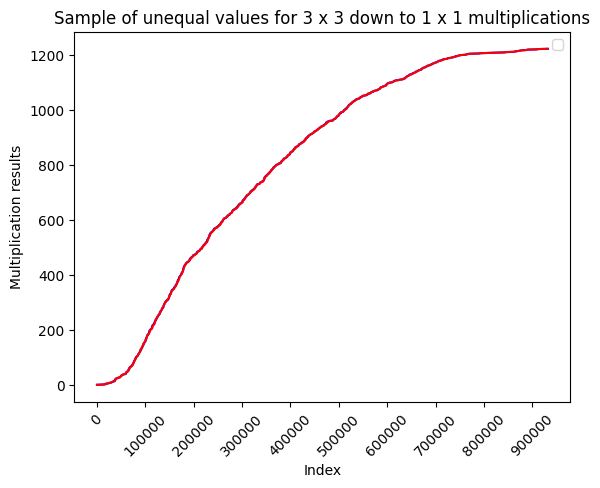

In [ ]:
import matplotlib.pyplot as plt
def plot(data):
  data = [x for x in data if x[0] != x[1]]
  print(data[0])
  actual = sorted([int(val[1]) for val in data])
  predicted = sorted([int(val[0]) for val in data])
  plt.plot(actual,np.arange(len(data)),color = "blue")
  plt.plot(predicted,np.arange(len(data)),color = "red")
  ticks = np.arange(0,max(predicted), 100000)
  #print(max(predicted))
  #print(len(ticks))
  plt.xticks(ticks, rotation=45)

  plt.title('Sample of unequal values for 3 x 3 down to 1 x 1 multiplications')
  plt.xlabel('Index')
  plt.ylabel('Multiplication results')
  plt.legend()

  #plt.savefig("figure.png")
  plt.show()

plot(data)